In [1]:
import numpy as np
import scipy.stats as stats

In [6]:
def bioassay(nchain, data, prop_sd, init):
    ## Echantillonneur de Gibbs sur l'exo 8 (bioassay et LD50)
    
    chain = np.zeros((nchain + 1, 2))
    chain[0,:] = init
    acc_rate = np.zeros(2)
    
    ndeaths = data["ndeaths"]##nombre de décès
    log_dose = data["log_dose"]##le dosage (log)
    nanimals = data["nanimals"]##les pauvres testeurs
    
    for idx in range(nchain):
        ## Etat actuel
        current = chain[idx,:]
        current_prob = np.exp(current[0] + current[1] * log_dose) / (1 + np.exp(current[0] + current[1] * log_dose))

        
        ## Mise à jour de beta0
        ## générons un candidat pour beta0
        prop = np.random.normal(loc = current[0], scale = prop_sd[0], size = 1)
        prop_prob = np.exp(prop + current[1] * log_dose) / (1 + np.exp(prop + current[1] * log_dose))
        
        top = np.sum(stats.binom.logpmf(ndeaths, nanimals, prop_prob))
        bottom = np.sum(stats.binom.logpmf(ndeaths, nanimals, current_prob))
        
        acc_prob = np.exp(top - bottom)
        if np.random.uniform(size = 1) < acc_prob:
            current[0] = prop
            current_prob = prop_prob
            acc_rate[0] += 1
        
        ## Mise à jour de beta1
        prop = np.random.normal(loc = current[1], scale = prop_sd[1], size = 1)
        prop_prob = np.exp(current[0] + prop * log_dose) / (1 + np.exp(current[0] + prop * log_dose))
        
        top = np.sum(stats.binom.logpmf(ndeaths, nanimals, prop_prob))
        bottom = np.sum(stats.binom.logpmf(ndeaths, nanimals, current_prob))
        
        acc_prob = np.exp(top - bottom)
        if np.random.uniform(size = 1) < acc_prob:
            current[1] = prop
            current_prob = prop_prob
            acc_rate[1] += 1
        
        ## Stockage du nouvel état
        chain[idx+1,:] = current
        
    return chain, acc_rate / nchain

In [10]:
import pandas as pd
data = pd.DataFrame({
    "log_dose": [-0.86, -0.3, -0.05, 0.73],
    "nanimals": [5] * 4,
    "ndeaths": [0, 1, 3, 5]
})

nchain = 10**4
prop_sd = [2, 10]
init = [0, 0]##proba de mourrir vaut 0.5 quelque soit le dosage
chain, acc_rate = bioassay(nchain, data, prop_sd, init)

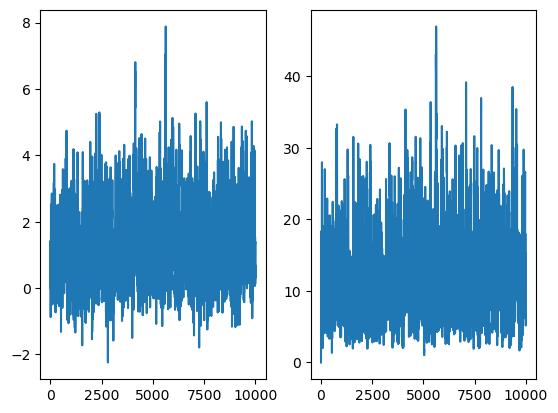

In [11]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(chain[:,0])

plt.subplot(1, 2, 2)
plt.plot(chain[:,1])

Nos chaines sont OK (je fais le bourrin pas de période de chauffe ni d'élagage). Passons à l'inférence notamment avec la loi a posteriori du $LD_{50}$.

/var/folders/2_/45c9y5ps2sg0zkm6twmxhdwc0000gn/T/ipykernel_2702/194401896.py:1: RuntimeWarning: invalid value encountered in divide
  LD50 = -chain[:,0] / chain[:,1]


(array([4.82655523e-02, 1.67466841e+00, 4.67298302e+00, 7.64204578e-01,
        1.20663881e-01, 2.12075912e-02, 5.11907373e-03, 4.38777748e-03,
        7.31296247e-04, 7.31296247e-04]),
 array([0.57424892, 0.71099241, 0.8477359 , 0.98447938, 1.12122287,
        1.25796636, 1.39470985, 1.53145334, 1.66819683, 1.80494032,
        1.9416838 ]),
 <BarContainer object of 10 artists>)

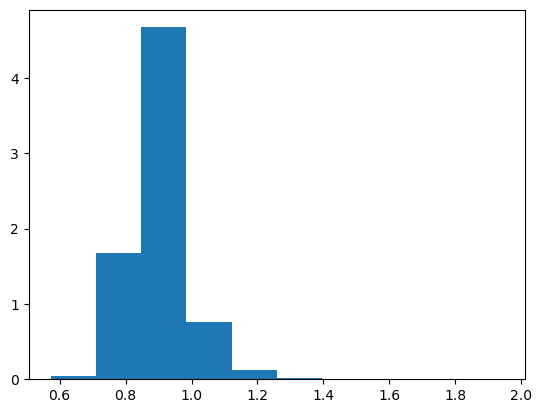

In [20]:
LD50 = -chain[:,0] / chain[:,1]
plt.hist(np.exp(LD50), density=True)

In [18]:
##Estimation ponctuelle par moyenne a posteriori
np.mean(LD50[1:])

-0.10666165130014635

In [19]:
## Intervalle de crédibilité
np.quantile(LD50[1:], q = [0.025, 0.975])

array([-0.2749895 ,  0.09854645])